# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [17]:
import numpy as np
import os
import requests
from tqdm import tqdm
from glob import glob
import zipfile

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline 

import torch

In [18]:
# defining dataset names and paths
BASE_URL = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/"
dog_dataset = "dogImages.zip"
human_dataset = "lfw.zip"

In [19]:
def download_dataset(dataset, base_url=BASE_URL, folder_to_extract=None):
    '''
    will download a dataset from provided url to the folder to extract if set
    
    Parameters:
    -----------
    dataset: string, name of dataset along with extension
    base_url: string, url from where extracting information
    folder_to_extract: string, optional. If not set it will be build from the name of the dataset
    '''
    if not folder_to_extract:
        try:
            folder_to_extract, _ = os.path.splitext(dataset)
            os.mkdir(folder_to_extract)
        except FileExistsError:
            print("Directory {} already exist, so skipping creation".format(folder_to_extract))
    
    full_url = os.path.join(base_url, dataset)
    folder_extract = os.path.join(folder_to_extract,dataset)
    
    if not os.path.exists(folder_extract):
        print("Downloading: {} and extracting to: {}".format(dataset, folder_to_extract))
    
        response = requests.get(full_url, stream=True)
        with tqdm.wrapattr(open(folder_extract, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=folder_extract) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)
    else:
        print("Dataset: {} already present in folder: {}".format(dataset, folder_to_extract))
    

In [20]:
def extract_dataset(dataset,extract_dir=None):
    ''' will extract the dataset on the fullpath 
      to the extract_dir defined if not then default to BASE_PATH
      Args:
        extract_dir (str): path to extract the zip file
        filename (str): zip filename
    '''
    
    if not extract_dir:
        extract_dir, _ = os.path.splitext(dataset)

    file_zip = os.path.join(extract_dir,dataset)
    zip_ref = zipfile.ZipFile(file_zip, 'r')
    zip_ref.extractall("./")
    zip_ref.close()

In [21]:
# download dog dataset 
download_dataset(dog_dataset)
extract_dataset(dog_dataset)

Directory dogImages already exist, so skipping creation
Dataset: dogImages.zip already present in folder: dogImages


In [22]:
# download human dataset 
download_dataset(human_dataset)
extract_dataset(human_dataset)

Directory lfw already exist, so skipping creation
Dataset: lfw.zip already present in folder: lfw


In [23]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [24]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

Number of faces detected: 1


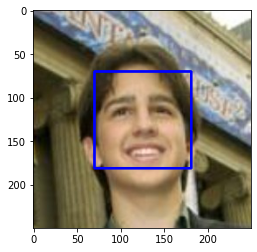

In [25]:
# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

'''
- Find faces in image
- Detects objects of different sizes in the input image. 
- The detected objects are returned as a list of rectangles.
'''
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [26]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [27]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [28]:
def human_detector_performance(image_path_list):
    '''
     Iterate over a list and count human faces present on it
     
     Parameters:
     ----------
     image_path_list: list, It's a list of paths where the image is located 
     
     Returns:
     
     float, representative % of the amount of images detected by the face_detector function
    '''
    counter = 0
    # Total of images to verify
    total = len(image_path_list)
    
    for img_path in image_path_list:
        counter += 1 if face_detector(img_path) else 0
    
    return (counter / total ) * 100

In [29]:
# Human Performance Detector on first 100 Images of human dataset
human_perf = human_detector_performance(human_files_short)

# Human Performance Detector on first 100 Images of dog dataset
dog_perf = human_detector_performance(dog_files_short)

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [30]:
for perf, name in zip((human_perf, dog_perf),('human','dog')):
    print("{:.2f} % of Images on first 100 images of {} dataset were detected as Humans".format(perf,name))

95.00 % of Images on first 100 images of human dataset were detected as Humans
7.00 % of Images on first 100 images of dog dataset were detected as Humans


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

## Using MTCNN Face detector

On the following snippets I will show how I've built a face detector and meausure its performance. 

First I started by reading some papers and watching videos about it that could give me a hint on how to do so. 

There is multiple techniques and algorithms, and it's also well known this techniques are publicly available and ready to use. Between the alternatives to use for the purpose of this project I've evaluated: 

1. [Multi-view Face Detection Using Deep Convolutional Neural Networks](https://arxiv.org/abs/1502.02766). This paper proposed to build a face detector relying on Deep CNN's for classification and feature extraction along with minimization of computational complexity. 
    
    The detector relies on the use of AlexNet and using multiple datasets to evaluate the detector such as: 
    - AFW [1]()
    - AFLW [2]()
    - PASCAL [3]()
    - FDDB [4]()
    
  The model itself consist of 8 layers where:
    - First 5 layers are Convolutional
    - Last 3 layers are fully connected 
    
  **Summary**: Even though the model proposed in this paper seems to have really good performance, I couldn't find a nice implementation ready to use or a guide on how to implement it by myself and I do believe it falls **out of scope** with the purpose of the project.
  
  
2.<span style="color: blue;">**SELECTED**</span>: [Joint Face Detection and Alignment using
Multi-task Cascaded Convolutional Networks](https://arxiv.org/pdf/1604.02878.pdf) This paper propose a frawework to integrate face detection and face alignment by using CNNs in 3 stages. 

   **Stages**: 

    1.- Use of cascade CNNs for joint face detection and alignment. Using a CNN called P-Net to obtain the candidate windows and their bounding box regression vectors. Then using [Non-Maximum Supression](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) to merge the overlapped candidates.

    2.- The candidates from previous stage are passed through a CNN called R-Net, where fale candidates are rejected, calibration is performed with bounding box and NMS merges. 
    
    3.- Similar to second stage but there is a task for describing the face with details and the network will output landmarks positions. 
    
    
I really like this model and could find a variety of tutorials on how to use MTCNN in multiple ML Frameworks / Libraries, such as Keras, Tensorflow and Pytorch.  

So I decided to go ahead and give a try by using: [Facenet Pytorch](https://github.com/timesler/facenet-pytorch)

> *A repository for Inception Resnet (V1) models in pytorch, pretrained on VGGFace2 and CASIA-Webface.*

In [31]:
from facenet_pytorch import MTCNN

In [32]:
from PIL import Image

In [33]:
# Verify is GPU is available :)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Create the instance of MTCNN
mtcnn = MTCNN(keep_all=False,min_face_size=150,post_process=False ,device=device)

In [35]:
def mtcnn_face_detector(img_path):
    ''' 
        Based on mtcnn will detect if there is a human face or not
        
        Parameters:
        -----------
        img_path: str, path to the picture to pass through the detector
        
        Returns: 
        boolean, True if a fase was detected, False otherwise
    '''
    # read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, _, _ =  mtcnn.detect(img,landmarks=True)
    
    return True if boxes is not None else False

In [36]:
for i in range(100):
    v = mtcnn_face_detector(human_files_short[i])
    if not v:
        print(i)

In [37]:
for i in range(100):
    v = mtcnn_face_detector(dog_files_short[i])
    if v:
        print(i)

37
40


In [38]:
def mtcnn_human_detector_performance(image_path_list):
    '''
     Iterate over a list and count human faces present on it
     
     Parameters:
     ----------
     image_path_list: list, It's a list of paths where the image is located 
     
     Returns:
     
     float, representative % of the amount of images detected by the face_detector function
    '''
    counter = 0
    # Total of images to verify
    total = len(image_path_list)
    
    for img_path in image_path_list:
        counter += 1 if mtcnn_face_detector(img_path) else 0
    
    return (counter / total ) * 100

In [39]:
# Human Performance Detector on first 100 Images of human dataset
human_perf = mtcnn_human_detector_performance(human_files_short)

# Human Performance Detector on first 100 Images of dog dataset
dog_perf = mtcnn_human_detector_performance(dog_files_short)

In [40]:
for perf, name in zip((human_perf, dog_perf),('human','dog')):
    print("{:.2f} % of Images on first 100 images of {} dataset were detected as Humans".format(perf,name))

100.00 % of Images on first 100 images of human dataset were detected as Humans
2.00 % of Images on first 100 images of dog dataset were detected as Humans


**NOTE**: 

As you can see I've managed to fine tune the MTCNN face detector to be able to detect 100% of the faces on the first 100 images and 2% only were reported as humans but they were not. 

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [42]:
import torch
import torchvision.models as models

In [43]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [44]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/udacity/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:27<00:00, 20.4MB/s] 


In [45]:
# Dictionary of pre-trained models to use :) 
pretrained = {'vgg16': VGG16, 'resnet18': None}

In [46]:
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [47]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [280]:
def process_image(img_path):
    '''
    Will open the image and apply transforms to it:
        - Resize
        - Conver to Tensor
        
    Parameters:
    -----------
    img_path: str, path to the image to load
    
    Returns:
    -------
    tensor, representing the transformed image as tensor 
    '''
    
    # Open the image
    #img = Image.open(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Transform the image by cropping to 224 by 224 
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
                                   ])
    # Apply the transform
    image_tensor = transform(img)
    return image_tensor

In [281]:
def pre_trained_predict(img_path, model):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Parameters:
    -----------
        img_path: str, path to an image to predict on
        model: torchvision.models, representation of the model to pass the image 
        on which will make the prediction on
        
    Returns:
    --------
        int, index corresponding to model's prediction
    '''
    
    model.cuda()
    # Let's process the image 
    img = process_image(img_path)
    # Convert to 1D vector
    image = img.unsqueeze_(0)
    
    with torch.no_grad():
        model.eval()
        output = model.forward(image.cuda())
        _, predicted = torch.max(output,1)
    
    preds = np.squeeze(predicted.numpy()) if not use_cuda else np.squeeze(predicted.cpu().numpy())
    return preds # predicted class index

In [282]:
# Testing the predict with one image from testing
path_to_dog = 'dogImages/test/133.Yorkshire_terrier/Yorkshire_terrier_08337.jpg'
print(pre_trained_predict(path_to_dog,pretrained['vgg16']))

193


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [171]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path,model):
    '''
    Will pass the image through the network and verify is within the range
    
    For dogs range is : 151 to 268 
    
    Parameters: 
    -----------
    img_path: str, path to the image to apply the dog detector
    model: torchvision.models to apply pass the prediction through
    
    Returns: 
    --------
    bool, True if predicted class falls between the range, False otherwise
    '''
    idx = pre_trained_predict(img_path,model)
    return True if idx >= 151 and idx <= 268 else False

In [172]:
### Testing the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def dog_detector_performance(image_path_list, model):
    '''
     Iterate over a list and count dog present on it
     
     Parameters:
     ----------
     image_path_list: list, It's a list of paths where the image is located 
     
     Returns:
     
     float, representative % of the amount of images detected by the face_detector function
    '''
    counter = 0
    # Total of images to verify
    total = len(image_path_list)
    
    for img_path in image_path_list:
        counter += 1 if dog_detector(img_path,model) else 0
    
    return (counter / total ) * 100

In [173]:
# Human Performance Detector on first 100 Images of human dataset
is_human_perf = dog_detector_performance(human_files_short,pretrained['vgg16'])

# Human Performance Detector on first 100 Images of dog dataset
is_dog_perf = dog_detector_performance(dog_files_short, pretrained['vgg16'])

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- 0.00 % of Images on first 100 images of human dataset were detected as Dogs
- 92.00 % of Images on first 100 images of dog dataset were detected as Dog

In [175]:
for perf, name in zip((is_human_perf, is_dog_perf),('human','dog')):
    print("{:.2f} % of Images on first 100 images of {} dataset were detected as Dogs".format(perf,name))

0.00 % of Images on first 100 images of human dataset were detected as Dogs
92.00 % of Images on first 100 images of dog dataset were detected as Dogs


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [176]:
### Applied the same technique but for Resnet18 
resnet18 = models.resnet18(pretrained=True)

In [177]:
pretrained['resnet18'] = resnet18 

In [178]:
# Human Performance Detector on first 100 Images of human dataset
is_human_perf = dog_detector_performance(human_files_short,pretrained['resnet18'])

# Human Performance Detector on first 100 Images of dog dataset
is_dog_perf = dog_detector_performance(dog_files_short, pretrained['resnet18'])

In [179]:
for perf, name in zip((is_human_perf, is_dog_perf),('human','dog')):
    print("{:.2f} % of Images on first 100 images of {} dataset were detected as Dogs".format(perf,name))

1.00 % of Images on first 100 images of human dataset were detected as Dogs
95.00 % of Images on first 100 images of dog dataset were detected as Dogs


### Observations: 

I've decided to go ahead and give a try to [Deep Residual Learning Networks](https://arxiv.org/pdf/1512.03385.pdf), especifically : **Resnet18**  

Once I've downloaded the pretrained network and apply the dog_detector with this network, I could observe a jump of 3% accuracy on the Dogs dataset when trying on the first 100 images. But also noticed a 1% percent jump which wasn't present on the vgg model on detecting Humans as dogs. Which means for each 100 humans pictures 1 is detected as a dog. 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel

- 
<img src="images/Brittany_02625.jpg" width="100"> 
<img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel

- 
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> 
<img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador

- 

<img src="images/Labrador_retriever_06457.jpg" width="150"> 
<img src="images/Labrador_retriever_06455.jpg" width="240"> 
<img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [59]:
import os
from torchvision import datasets, transforms

In [60]:
data_dir = './dogImages/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/valid'

In [61]:
# Training Transform 
train_transforms = transforms.Compose([transforms.RandomGrayscale(p=0.2),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225]),
                                      ])
# Validation Transform
valid_transforms = transforms.Compose([transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

In [62]:
# Test Transform
test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
                                     ])

In [63]:
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [64]:
# Testing the Loading of the classes 
assert train_data.classes[0] ==  '001.Affenpinscher'
train_data.classes[:5]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute']

In [65]:
# define dataloader parameters
batch_size = 20
num_workers= 0

In [66]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [67]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [68]:
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [69]:
# Load the dataloaders in a dictionary, so it can be referenced later 
loaders_scratch = {'train': train_loader, 'test': test_loader, 'valid': valid_loader}

In [241]:
def process_classes(class_list):
    ''' 
     Process the list of strings with format xxx.yyy_yyy
     to a map with xxx as the index of the class and yyy to the name of the class
     
     Parameters:
     ----------
     
     class_list: list, contains a list of dog breeds
     
     Returns:
     dict: with the format {index: dog breed} 
     where index is the id of the breed as key and the breed as the value mapping to ImageNet Dictiorary
     ref: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a 
    '''
    idx_to_class = {}
    for class_str in class_list:
        idx, breed = class_str.split('.')
        breed = breed.replace('_', ' ').title()
        idx_to_class[int(idx)] = breed
    return idx_to_class

In [242]:
dog_idx_to_class  = process_classes(train_data.classes)
print(dog_idx_to_class[5])

Alaskan Malamute


In [243]:
# A(mount of dog classes
num_classes = len(train_data.classes)
num_classes

133

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?

**Answer**: I decided to resize and **randomresizecrop** my images on training and **centercrop** on testing and validation sets. Also decide the size to be 224x224 because I would like to follow an approach similar to the vgg16 paper where the size of the image was as mentioned before. 

- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: I did apply the following transforms to the training data in order to add Augmentation

- RandomHorizontalFlip
- RandomRotation
- RandomGrayScale
- RandomResizeCrop 

The validation and testing set where only resized to be 224 by 244 pixels as this is the size the network would expect, but didn't apply any transforms to it as We would like to apply those over training so the network could try to learn different rotations, colors schemes like grayscale and flips. 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

In [74]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # 1st convolutional layer sees image: ( 3*224*224) 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # 2nd convolutional layer sees image: (16*112*112)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 3rd convolutional layer sees image: (32*56*56)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        # 3rd convolutional layer sees image: (64*28*28)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 3rd convolutional layer sees image: (64*14*14)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Linear Layer 64 channels * 7 * 7 pix --> 1024
        self.fc1 = nn.Linear(64*7*7,1024)
        # Linear Layer 1024 --> 512 
        self.fc2 = nn.Linear(1024,512)
        # Output layer 512 --> 133 classes 
        self.out = nn.Linear(512,133)
        # Dropout layer with 30% probability of turning off neurons
        self.dropout = nn.Dropout(p=0.3)
        
    
    def forward(self, x):
        ## Define forward behavior
        # Sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten image input
        x = x.view(-1, 64 * 7 * 7 )
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        x = self.out(x)
        return x

### Applying weight initialization 

As I saw on lesson 4 an important fact from making your network to perform better during training is considering weight initialization. 

In this case I opted for using Weight initialization on Fully connected Linear layers following the Normal distribution based on the input_features on each layer as follows:

#### Input Features on Layers:

- **fc1**: 3136 features
- **fc2**: 1024 features
- **out**: 512 features (output layer)

In [75]:
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features # on each layer take its input neurons number
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(std=y)
        m.bias.data.fill_(0)  

In [76]:
#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
# Apply weight initialization
model_scratch.apply(weights_init_normal)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  
Approaches: 

1.- **2 Convolutional Layers , 2 Fully connected Layers** 

- I started by outlining a simple architecture with few convolutional layers (2) and 2 fully connected layers.
- After running the network I couldn't get passed through 1% accuracy on testing. 
- Additionally to this, I noticed the amount of parameters as input were too big and the GPU was not doing well and exiting with some errors due to memory limits. So I decided to move to next approach. 
- Optimizer used: Stochastic Gradient Descent

2.- **Variations between Conv layers and Fully connected layers**

- I have tried multiple combinations, one of them was having 3 conv layers and 2 to 3 fully connected layers. But still couldn't achieve good performance. 
- Then when back to the statement and thought about this:
> Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.

- Then decided to change my transformers and use only grayscale pictures, thinking that by eliminating color my network would perform better but my assumption was quite wrong so I reverted back on the next approach.

3.- <span style="color: blue;">**SELECTED: 5 Convolutional Layers, 3 Fully connected Layers**</span>.

- After trying with multiple combinations once of the architectures that worked out well was this one. 
- 5 Convolutional Layers, initially receiving pictures of 224 by 224 pixels with 3 channels (RGB), passing a Kernel size of 3 by 3 on each layer and using padding of 1
- 3 Fully connected layers 
- Loss function: Cross Entropy Loss 
- Optimizer: Adam 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [77]:
import torch.optim as optim

### Selected Categorical Cross Entropy loss
criterion_scratch = nn.CrossEntropyLoss()

learning_rate = 0.0001
### TODO: select optimizer
optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), learning_rate)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [78]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [79]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            #print(data.shape)
            # clear the gradients
            optimizer.zero_grad()
            
            # forward pass 
            output = model(data)
                
            ## find the loss and update the model parameters accordinglymodel_512
            loss = criterion(output, target)
            
            # apply backpropagation 
            loss.backward()
            
            # Update the weights 
            optimizer.step()
            
            train_loss += loss.item()*data.size(0)
               
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            
            valid_loss += loss.item() * data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss        
            
    # return trained model
    return model

In [80]:
# Name of the model
model_50_epochs  = 'model_scratch_50.pt'

In [129]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda,model_50_epochs )

Epoch: 1 	Training Loss: 4.717980 	Validation Loss: 4.587162
Validation loss decreased (inf --> 4.587162).  Saving model ...
Epoch: 2 	Training Loss: 4.639523 	Validation Loss: 4.456141
Validation loss decreased (4.587162 --> 4.456141).  Saving model ...
Epoch: 3 	Training Loss: 4.574130 	Validation Loss: 4.429980
Validation loss decreased (4.456141 --> 4.429980).  Saving model ...
Epoch: 4 	Training Loss: 4.514027 	Validation Loss: 4.372387
Validation loss decreased (4.429980 --> 4.372387).  Saving model ...
Epoch: 5 	Training Loss: 4.483896 	Validation Loss: 4.369093
Validation loss decreased (4.372387 --> 4.369093).  Saving model ...
Epoch: 6 	Training Loss: 4.436761 	Validation Loss: 4.304574
Validation loss decreased (4.369093 --> 4.304574).  Saving model ...
Epoch: 7 	Training Loss: 4.379434 	Validation Loss: 4.271868
Validation loss decreased (4.304574 --> 4.271868).  Saving model ...
Epoch: 8 	Training Loss: 4.353668 	Validation Loss: 4.285478
Epoch: 9 	Training Loss: 4.325972 

In [81]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(model_50_epochs))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [82]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        #test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct/total, correct, total))

In [83]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.592923


Test Accuracy: 16% (138/835)


### Observations

As you can see with the network architecture pre-defined above and by training during 50 epochs, I could achieve **16% accuracy** on the test set. Let's see how far I could get by using pre-trained models available.

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [84]:
## Using same data loaders as before 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [85]:
import torchvision.models as models
import torch.nn as nn

In [91]:
## Model architecture
model_transfer = models.resnet152(pretrained=True)

In [134]:
if use_cuda:
    model_transfer = model_transfer.to(device)

In [136]:
print("Layer to modify :)")
model_transfer.fc

Layer to modify :)


Linear(in_features=2048, out_features=133, bias=True)

In [642]:
# Freeze training for all "features" layers
def freeze_weights(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False    

In [644]:
feature_extract = True
# Freeze weights 
freeze_weights(model_transfer, feature_extract)
# Get the in_features on the classifier 
num_features = model_transfer.fc.in_features
# Modify the classifier with the number of classes, in this case 133
model_transfer.fc = nn.Linear(num_features, num_classes).cuda()

In [645]:
# Apply weight initialization
model_transfer.apply(weights_init_normal)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Between the reasons for using the selected network **resnet152**, was I already worked with previous and smaller networks architectures before such as: Vgg16 and Resnet18, and this time I was interested to see how a task like classification will perform on a deeper network such  as the one mentioned above. 

Resnet152, seems to be a really good network for classification because the deeper the network the better performance it could have in terms of learning and feature extraction. 

One of the things learned from **transfer learning lesson** was you could practically make use of the pretrained network for different purposes such as: 
- Feature extractor 
- Fine tuning or better to say a starter point for training better suitable for large datasets 

Decision was based on the fact of having a small dataset and a pretrained model on ImageNet dataset which contains already 133 classes for dogs. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

### Observations:

As we are doing feature extraction, let's check which weights we will be updating. In this case the last layer, referred as fc 

In [646]:
params_to_update = model_transfer.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_transfer.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_transfer.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [647]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [649]:
# Load the dataloaders in a dictionary, so it can be referenced later 
loaders_transfer = {'train': train_loader, 'test': test_loader, 'valid': valid_loader}

In [652]:
n_epochs = 15

In [654]:
# train the model
model_transfer = train(n_epochs, 
                       loaders_transfer, 
                       model_transfer, 
                       optimizer_transfer, 
                       criterion_transfer, 
                       use_cuda, 
                       'model_transfer.pt')

Epoch: 1 	Training Loss: 2.505880 	Validation Loss: 1.842444
Validation loss decreased (inf --> 1.842444).  Saving model ...
Epoch: 2 	Training Loss: 1.961336 	Validation Loss: 1.466333
Validation loss decreased (1.842444 --> 1.466333).  Saving model ...
Epoch: 3 	Training Loss: 1.658526 	Validation Loss: 1.256349
Validation loss decreased (1.466333 --> 1.256349).  Saving model ...
Epoch: 4 	Training Loss: 1.488315 	Validation Loss: 1.104895
Validation loss decreased (1.256349 --> 1.104895).  Saving model ...
Epoch: 5 	Training Loss: 1.369735 	Validation Loss: 1.034595
Validation loss decreased (1.104895 --> 1.034595).  Saving model ...
Epoch: 6 	Training Loss: 1.269202 	Validation Loss: 0.954330
Validation loss decreased (1.034595 --> 0.954330).  Saving model ...
Epoch: 7 	Training Loss: 1.209901 	Validation Loss: 0.914364
Validation loss decreased (0.954330 --> 0.914364).  Saving model ...
Epoch: 8 	Training Loss: 1.168573 	Validation Loss: 0.892637
Validation loss decreased (0.91436

In [655]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [656]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.734085


Test Accuracy: 80% (673/835)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [657]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
# Replacing by previously created dictionary
class_names = dog_idx_to_class

In [658]:
def predict_breed_transfer(img_path, top_k=1):
    # load the image and return the predicted breed
    img = process_image(img_path)
    image = img.unsqueeze_(0)
    
    
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image = image.cuda()    
    
    with torch.no_grad():
        model_transfer.eval()
        output = model_transfer(image)
        _, predicted = torch.max(output,1)
        
    preds = np.squeeze(predicted.numpy()) if not use_cuda else np.squeeze(predicted.cpu().numpy())

    # Adding +1 to the prediction since the 133 classes start from 1
    return int(preds) + 1

In [659]:
dog = 'dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg'
print(dog)
x = predict_breed_transfer(dog)

dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg


In [660]:
if x in class_names:
    print("Predicted Dog Breed: {}".format(class_names[x]))

Predicted Dog Breed: Affenpinscher


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [661]:
from IPython import display
import matplotlib.image as mpimg

In [662]:
titles = {'dog': "It  looks like your breed is {}", 
          'human': "Hey Hooman, maybe your are similar to:\n {} dog :) \n don't you think?",
          'error': "You are neither a dog or a hooman, are u a UFO maybe?"}

In [722]:
def show_img(img_name, class_name, type_of_img):
    
    text_breed = titles[type_of_img].format(class_name)
    
    if type_of_img !='error':
        fig, ax = plt.subplots(figsize=(5,5), ncols=1)
        image = mpimg.imread(img_name)
        plt.imshow(image)
        ax.axis('off')
    else:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(5,5))
        img = mpimg.imread('./dog_breed_imgs/alien.jpg')
        image = mpimg.imread(img_name)
        ax1.imshow(image)
        ax2.imshow(img)
        ax1.axis('off')
        ax2.axis('off')
        
    plt.figtext(0.5, 0.07, text_breed, horizontalalignment='center', backgroundcolor=plt.cm.tab20c(14))    
    fig.suptitle(x=0.5, y=0.93 , t='Hello there :)', fontsize=12, fontweight='bold')
    
    

In [723]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    is_a_dog = dog_detector(img_path,pretrained['resnet18'])
    is_a_human = mtcnn_face_detector(img_path)
    
    if is_a_dog: 
        idx = predict_breed_transfer(img_path)
        show_img(img_path,class_names[idx], 'dog')
    elif is_a_human:
        idx = predict_breed_transfer(img_path)
        show_img(img_path,class_names[idx], 'human')
    else:
        show_img(img_path,"", 'error')

In [724]:
test_path = "./dog_breed_imgs/test"

In [725]:
def get_path(img_name):
    return os.path.join(test_path, img_name)

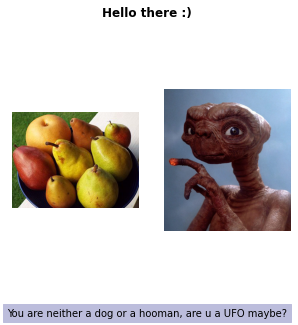

In [726]:
run_app(get_path('pear.jpg'))

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__

6.a) Is the output better than you expected? 

 I really had lots of fun by passing the new images through the model to get a prediction and indeed the ouput is better than I expected but I think It could be way better and improved in multiple was mention as follows: 
 
 - **Accuracy of the model using resnet152** is 80% by training for 15 epochs, meaning that for every 10 images passing through the model 2 are incorrect, I would try perhaps training for more epochs.
 - **Weight initialization**, I have used the weight initialization based on standard normal on the last layer, which was the layer I have updated. But perhaps by not using it or using a different technique on weight initialization the network will perform better.
 - **Adding more fully connected layers**, I have only added 1 fully connected layer, but I think it could be possible to add more layers at the end to validate if the classification algorithm improves. 
 - **Optimizer**, last but not least, It could be possible to change the optimizer for another one such as Adam Optimizer, which might perform better in reaching the minimum. 
 - **Attempt using other pretrained models**, Before attempting Resnet152, I was trying to get the Inception V3 model but it wasn't downloading so I use my plan B: resnet152. I would like potentially to try out building the classifier using other pretrained models and evaluate how this ones perform.
 

In [740]:
# Load test Images
dog_images = np.array(glob("./dog_breed_imgs/test/dogs/*"))
humans_images = np.array(glob("./dog_breed_imgs/test/humans/*"))

In [741]:
def show_predictions(list_of_images):
    for file in np.hstack(list_of_images):
        run_app(file)

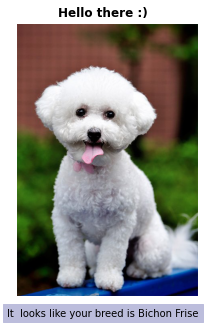

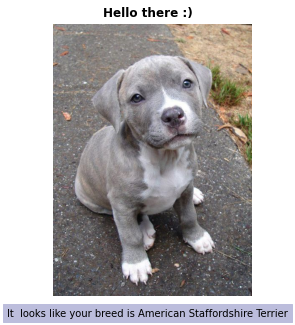

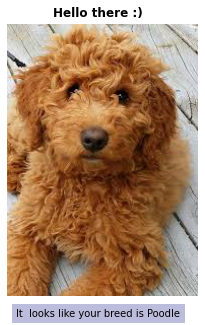

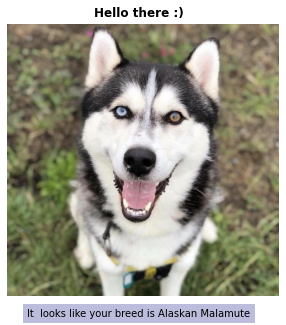

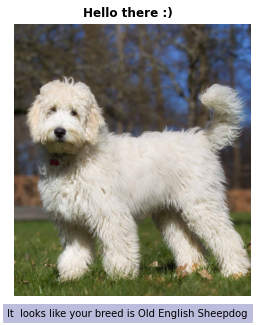

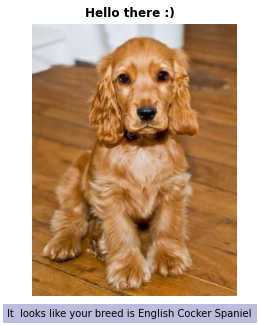

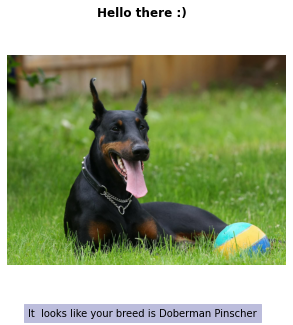

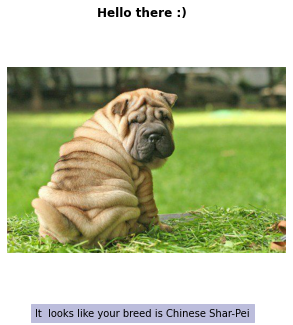

In [742]:
show_predictions(dog_images)

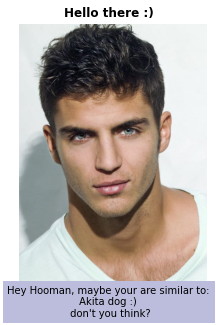

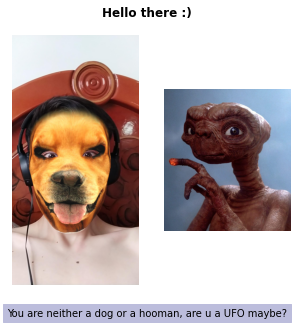

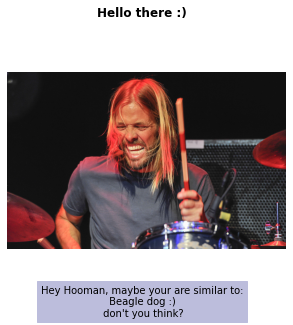

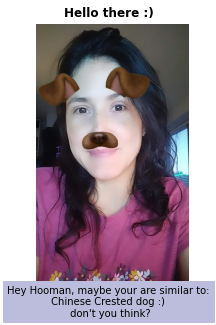

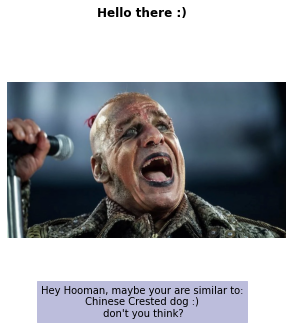

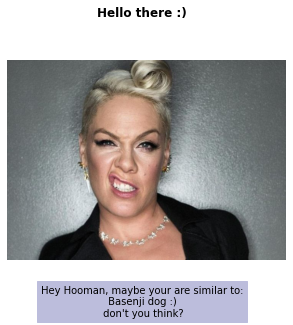

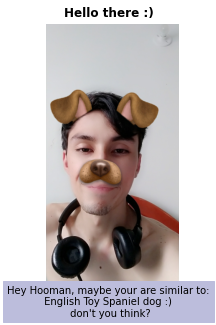

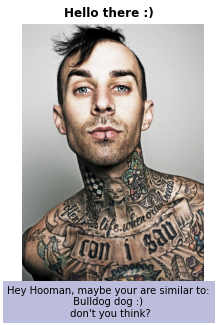

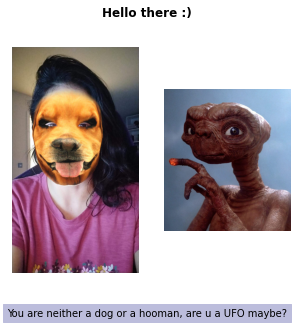

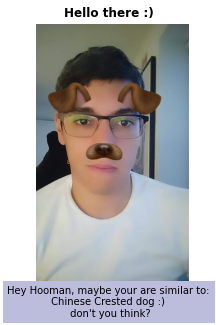

In [734]:
show_predictions(humans_images)